# PileCore

______________________________________________________________________

**Authors: Thijs Lukkezen & Robin Wimmers**

This notebook shows how to perform a pile bearing calculation with PileCore for multiple CPTs.

The structure of the tutorial is as follows:

- [Project definition](#Input-definition)
- [Download CPT's in project](#Download-CPTs-in-project)
- [Classify CPTs](#Classify-CPTs)
- [Call PileCore-API](#Call-PileCore-API)
- [View Results](#View-Results)
- [Report](#Report)
- [Grouper](#Grouper)
- [View Grouper Results](#View-Grouper-Results)

As usual, we start to install and import the libraries that are needed for this notebook.

In [1]:
# %matplotlib widget

import datetime
import os
import io
from typing import Any, Dict, Hashable, Mapping, Tuple, List
import logging

import numpy as np
import pandas as pd
import pygef
from matplotlib import pyplot as plt
from pygef.cpt import CPTData

from IPython.display import display
from nuclei.client import NucleiClient
from pygef.plotting import plot_cpt
from tqdm import tqdm

from pypilecore import api, create_basic_pile
from pypilecore.common.piles.grid import PileGridProperties
from pypilecore.input.tension import (
    create_multi_cpt_payload,
    create_multi_cpt_report_payload,
)
from pypilecore.results import (
    CasesMultiCPTBearingResults,
)
from pypilecore.results.tension_multi_cpt_results import MultiCPTBearingResults
from pypilecore.viewers import (
    ViewerCptResults,
    ViewerCptResultsPlanView,
    ViewerCptGroupResults,
)

pd.set_option("display.max_columns", None)
logging.getLogger().setLevel(logging.INFO)

### Start a Nuclei client session

In the next cell we will create a nuclei-client with a session that takes care of the
authentication and communication with the Nuclei server.

You will need to provide your user token, which can be obtained by login in to the [nuclei website](https://nuclei.cemsbv.io/) with your personal credentials and going to the "API Access Tokens" section.

<div style="background: #f2ed4c;
            width: 100%;
            color: black;
            text-align: center;">
<b>USER INPUT REQUIRED BELOW:<b>
</div>

In [2]:
# os.environ["NUCLEI_TOKEN"] = "<YOUR TOKEN>"

client = NucleiClient()

client.routing["PileCore"]["v3"] = "http://localhost:8000/"
client.session.verify = False

INFO:root:user token found in environment


# Input definition

#### General input

In [3]:
# General input data
project_id = 21305
project_remark = "Voorbeeld Notebook"  # Optional additional information
author = "N. Uclei"
project_name = "Automated pile design"

#### Soil Investigation input

In [4]:
# Specify CPT selection

# ** cpt_selection
# Specify a list of CPTs names (i.e. BRO ID).
cpt_selection = [
    "CPT000000059020",
    "CPT000000061575",
    "CPT000000061576",
    "CPT000000061577",
    "CPT000000061578",
    "CPT000000061579",
    "CPT000000061580",
    "CPT000000064642",
]


# ** classify_metode:
# Metode used to classify CPT data.
# Accepted values: ["beenJefferies", "machineLearning", "nen", "table", "robertson", "ntype"]
classify_metode = "ntype"

#### Geometry input

In [5]:
# ** pile_tip_levels_nap
# These are the levels (w.r.t. NAP) at which the bearing capacities will be calculated
# It can be a list, or any other sequence, such as a numpy array.
pile_tip_levels_nap = np.arange(-15, -25, -0.5)

# ** pile_head_level_nap
# The level of the pile-head [m] w.r.t. NAP.
# Must be a number, or the string "surface". In the latter case, the pile-head will be
# situated at the level of the original CPT surface level.
pile_head_level_nap = "surface"

# ** groundwater_level
# The groundwater-level in the project (w.r.t. NAP). Will have an impact on the
# classification and on the calculated soil-stresses.
# When None, the water-level of the CPTs is used.
groundwater_level_nap = None

#### Excavation input

In [6]:
# ** excavation_depth_nap:
# The depth [m w.r.t. NAP] of the service-level after excavation.
# Has to be below the origin al service-level of the CPT.
excavation_depth_nap = -3

# ** excavation_param_t:
# Required when providing an excavation_depth. The values can be:
# - 1.0: if installation is not low in vibration (niet-trillingsarm) and piles are installed after excavating
# - 0.5: (wortel-methode) if piles have been installed before excavation or installation is low-vibrating
excavation_param_t = 1.0

#### Construction and loads input

In [7]:
# ** stiff_construction:
# The stiffness of the construction has an influence on the value of xi.
# Accepted values: [True, False]
stiff_construction = False

# ** pile_load_sls_max
# Maximum tension force on pile Ft;max;k. Note that only positive
# values (tension force) are accepted.
pile_load_sls_max = 350

# ** pile_load_sls_min
# Minimum tension force (or maximum compression force) on pile
# -Ft;min;k (tension > 0). Positive values (tension force), negative
# values (compression force) and 0.0 are accepted. Note that the
# positive must be <= `pile_load_sls_max`
pile_load_sls_min = 0

# ** soil_load_sls:
# The overburden-pressure at surface-lpile_gridevel [kPa]
# If None, the default is 0.0
soil_load_sls = 0

#### top of tension zone

In [8]:
# ** top_of_tension_zone_nap
# Level (w.r.t. NAP) for with the bearing capacity we be calcualted.
# If None top_of_tension_zone_nap will be pile_head_level_nap.
top_of_tension_zone_nap = None

# ** Overrule top_of_tension_zone_nap for specific CPTs
# If desired, you can also specify top_of_tension_zone_nap values per CPT
# The values provided below will overwrite the top_of_tension_zone_nap for those specific CPTs.

# ** individual_top_of_tension_zone_nap
# dictionary with key cpt name and top_of_tension_zone_nap value
# e.g.: {"S03": 1.5}
individual_top_of_tension_zone_nap: Mapping[Any, float] = {}

#### OCR input

In [9]:
# ** ocr
# The Over-Consolidation-Ratio [-] of the foundation layer.
# If None, an OCR of 1.0 is assumed.
ocr = None

# ** Overrule OCR for specific CPTs
# If desired, you can also specify OCR values per CPT
# The values provided below will overwrite the OCR for those specific CPTs.

# ** individual_ocr
# dictionary with key cpt name and OCR value
# e.g.: {"S03": 1.5}
individual_ocr: Mapping[Any, float] = {}

#### Safety Factors input

In [10]:
# ** gamma_gamma
# Partial factor for volumetric soil weight. A.3.2 NEN 9997-1+C2 (nl)
# Geotechnisch ontwerp van constructies - Deel 1 Algemene regels [2017]
# If None, the default is 1.1
gamma_gamma = 1.1

# ** gamma_r_s
# Safetyfactor on the sleeve-friction bearing capacity
# If None, the default is 1.2
gamma_r_s = 1.2

# ** gamma_r_b
# Safetyfactor on the pile-tip bearing capacity
# If None, the default is 1.2
gamma_r_b = 1.2

# ** gamma_f_nk
# Safetyfactor on the negative friction
# Note: Use 1.4 if bottom negative friction ≠ positive friction
# If None, the default is 1.0
gamma_f_nk = 1.0

# ** gamma_s_t
# Pile resistance factor gamma_s;t used to compute the
# design cone resistance values qc;z;d as prescribed in NEN 9997-1+C2_2017 7.6.3.3(d).
# If None, the default is 1.35
gamma_s_t = 1.35

# ** overrule_xi
# Sets a fixed value for xi
overrule_xi = None

## Pile input
---


In [11]:
# ** pile_name
# The name of the pile (For potential plotting purposes)
pile_name = None

### Standard piles

Choose a `main_type`, `specification` and `installation` (optional) value to define a standard pile according to the NEN9997-1 or CUR236 definitions.

You can also leave the standard pile definition empty and define all pile attributes manually.

#### NEN9997-1
![NEN9997-1a](./img/standard_piles-NEN9997-1.png)

#### CUR-236
![CUR236a](./img/standard_piles-CUR236.png)

In [12]:
# Standard Pile definition

# ** standard
# The choice of "standard" from one of the tables below.
# Accepted values: ["NEN9997-1", "CUR236"]
standard = "CUR236"

# ** main_type
# The choice of "main_type" from one of the tables below.
# Accepted values: ["concrete", "steel", "wood", "anchor"]
main_type = "anchor"

# ** specification
# The "specification" section in the table below.
specification = "1"

# ** installation
# The English-equivalent of the "Installatie" section in the table below.
installation = "B"

### Pile Geometry
![pile_geometry_definitions](./img/pile_geometry_definitions.png)

In [13]:
# ** pile_shape
# The shape of the pile
# Accepted values: ["round", "rectangle"]
pile_shape = "round"

# ** height_base
# Height of pile base [m]. If None, a pile with constant dimension is inferred.
# Cannot be None if the shaft dimensions are not equal to the base dimensions.
height_base = None

### Rectangular pile dimensions

Only fill these values if the `pile_shape` == "rectangle". Otherwise they are ignored

The pile geometry is defined as a "core" and "shell" segment. First we define the "core",
which is a required part that should always be there for a rectangular pile.

In [14]:
# ** core_secondary_dimension
# Largest cross-sectional dimension of the core component [m].
core_secondary_dimension = 0.40

# ** core_tertiary_dimension
# Smallest cross-sectional dimension of the core component [m].
# If None, a square core is inferred.
core_tertiary_dimension = None

# Base dimensions (optional)
# --------------------------
# Optionally, we can define a "base" segment. This segment should have larger dimensions than the core.
# Make sure to also fill a value for the `height_base` (in the general geometry cell above).

# ** base_secondary_dimension
# Largest cross-sectional dimension of the widened-base component [m].
base_secondary_dimension = None

# ** base_tertiary_dimension
# Smallest cross-sectional dimension of the widened-base component [m].
# If None, a square base is inferred.
base_tertiary_dimension = None

### Round pile dimensions

Only fill these values if the `pile_shape` == "round". Otherwise they are ignored

The pile geometry is defined as a "core" and "shell" segment. First we define the "core",
which is a required part that should always be there for a round pile.

In [15]:
# ** core_diameter
# Diameter of the core component [m].
core_diameter = 0.40

# Base dimension (optional)
# --------------------------
# Optionally, we can define a "base" segment. This segment should have larger dimensions than the core.
# Make sure to also fill a value for the `height_base` (in the general geometry cell above).

# ** base_diameter
# Diameter of the widened-base [m].
# If null, a pile with constant diameter (diameter_base) is inferred.
base_diameter = 0.5

### Optionally overwriteable pile input

If you want to use the default pile specifications you can ignore this section. Any
value provided will overwrite the default value.

In [16]:
# Optional Input

# ** pile_material
# The material name of the pile. If a standard pile was selected, the material is
# inferred, but can be overwritten. Default materials are: "concrete", "steel", "wood".
# Custom materials can be defined below.
pile_material = None

# ** custom_material
# A custom material definition. Assign the "name" property as `pile_material` to use it.
# example:
# custom_material = {
#     "name": "custom_material",
#     "elastic_modulus": 15e3,    # [MPa]
#     "color": "#ff0000",        # Hexadecimal color
# }
custom_material = None

# ** settlement_curve
# Settlement lines for figures 7.n and 7.o of NEN-9997-1 As defined in table 7.c of
# NEN-9997-1. The value is inferred from the pile_type_specifications, but can be
# overwritten
settlement_curve = None

# ** adhesion
# Optional adhesion value, use it if the pile shaft has undergone a special treatment.
# Examples:
# - adhesion = 50 kN/m2 for synthetic coating
# - adhesion = 20 kN/m2 for bentonite
# - adhesion = 10 kN/m2 for bitumen coating
# See 7.3.2.2(d) of NEN 9997-1 for examples.
adhesion = None  # kPa

# ** alpha_p
# Alpha p factor used in pile tip resistance calculation. The value is inferred from the
# pile_type_specifications, but can be overwritten.
alpha_p = None

# ** alpha_s_clay
# Alpha s factor for soft layers used in the positive friction calculation. If None the
# factor is determined as specified in table 7.d of NEN 9997-1.
alpha_s_clay = None

# ** alpha_s_sand
# Alpha s factor for coarse layers used in the positive friction calculation. The value
# is inferred from the pile_type_specifications, but can be overwritten.
alpha_s_sand = None

# ** alpha_t_clay
# Alpha t factor for soft layers used in the positive friction calculation. If None the
# factor is determined as specified in table 7.d of NEN 9997-1.
alpha_t_clay = None

# ** alpha_t_sand
# Alpha t factor for coarse layers used in the positive friction calculation. The value
# is inferred from the pile_type_specifications, but can be overwritten.
alpha_t_sand = None

# ** beta_p
# Beta_p used in pile tip resistance calculation as per NEN 9997-1 7.6.2.3 (h). The
# value is inferred from the pile dimension properties, but can be overwritten
beta_p = None

# ** pile_tip_factor_s
# Factor s used in pile tip resistance calculation as per NEN 9997-1 7.6.2.3 (h). The
# value is inferred from the pile dimensions and soil properties, but can be overwritten.
pile_tip_factor_s = None

# ** is_auger
# Determines weather the pile the pile is an auger pile or not. The value is inferred
# from the pile_type_specifications, but can be overwritten.
# Accepted values: [True, False, None]
is_auger = None

# ** is_low_vibrating
# Determines weather the pile has an installation type with low vibration. The value is
# inferred from the pile_type_specifications, but can be overwritten.
# Accepted values: [True, False, None]
is_low_vibrating = None

# ** negative_fr_delta_factor
# factor * φ = δ. This parameter will be multiplied with phi to get the delta parameter
# used in negative friction calculation according to NEN-9997-1 7.3.2.2 (e). Typically
# values are 1.0 for piles cast in place, and 0.75 for other pile types. The value is
# inferred from the pile_type_specifications, but can be overwritten.
negative_fr_delta_factor = None

### Create Pile

In [17]:
pile = create_basic_pile(
    pile_name=pile_name,
    main_type=main_type,
    specification=specification,
    installation=installation,
    pile_shape=pile_shape,
    height_base=height_base,
    core_secondary_dimension=core_secondary_dimension,
    core_tertiary_dimension=core_tertiary_dimension,
    base_secondary_dimension=base_secondary_dimension,
    base_tertiary_dimension=base_tertiary_dimension,
    core_diameter=core_diameter,
    base_diameter=base_diameter,
    pile_material=pile_material,
    custom_material=custom_material,
    settlement_curve=settlement_curve,
    adhesion=adhesion,
    alpha_p=alpha_p,
    alpha_s_clay=alpha_s_clay,
    alpha_s_sand=alpha_s_sand,
    beta_p=beta_p,
    pile_tip_factor_s=pile_tip_factor_s,
    is_auger=is_auger,
    is_low_vibrating=is_low_vibrating,
    negative_fr_delta_factor=negative_fr_delta_factor,
)

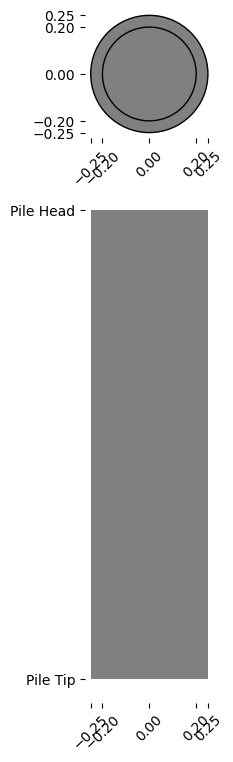

In [18]:
pile.geometry.plot();

### Other input

Some other input values.

In [19]:
# ** void_ratio_max
# Maximum void ratio of the soil (the loosest packing). The influence
# of this parameter is limited, and therefore it is typically
# sufficient to provide a global estimation. For normally consolidated
# sands in The Netherlands, an emax = 0.80 can be used in most cases.
void_ratio_max = 0.8

# ** void_ratio_min
# Minimum void ratio of the soil (the densest packing). The influence
# of this parameter is limited, and therefore it is typically
# sufficient to provide a global estimation. For normally consolidated
# sands in The Netherlands, an emin = 0.40 can be used in most cases.
void_ratio_min = 0.4

In [20]:
# ** center_to_center_distance
# Centre to centre distance of regular grid [m]
center_to_center_distance = 3

# ** pile_location
# - center pile `pile_location= 4`
# - middle pile `pile_location= 1 or 3 or 4 or 5 or 7`
# - corner pile `pile_location= 0 or 2 or 6 or 8`

#     6 --- 7 --- 8
#     |     |     |
#     3 --- 4 --- 5
#     |     |     |
#     0 --- 1 --- 2   with --- is | is center_to_center_distance
pile_location = 1

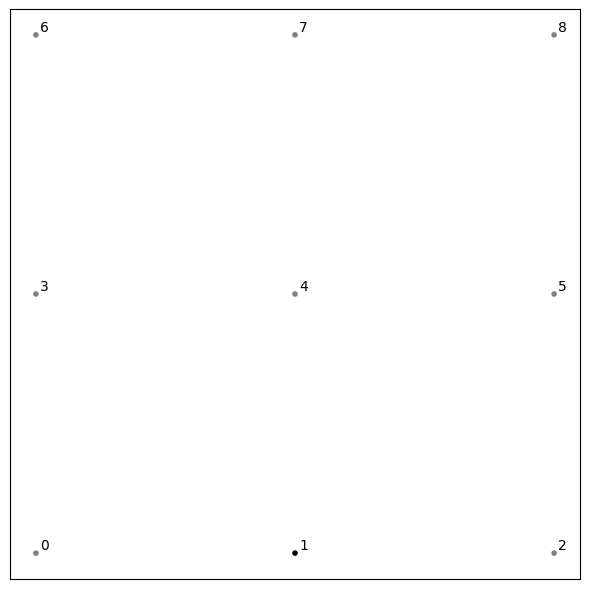

In [21]:
if center_to_center_distance:
    pile_grid = PileGridProperties.regular(
        ctc=center_to_center_distance, index_location=pile_location
    )
    pile_grid.plot_overview()
else:
    pile_grid = None

### Report content

These values define the content of the report

In [22]:
# ** group_results_content
# Whether or not to add a section with the results of all CPTs considered as one
# statistical group.
# Accepted values: [True, False]
group_results_content = True

# ** individual_cpt_results_content
# Whether or not to add a separate result section for each individual CPT.
# Accepted values: [True, False]
individual_cpt_results_content = True

# ** result_summary_content
# Whether or not to add a summary of all results in the beginning of the report.
# Accepted values: [True, False]
result_summary_content = True

<div style="background: #f2ed4c;
            width: 100%;
            color: black;
            text-align: center;">
<b>END USER INPUT<b>
</div>

After this point, modifications are for expert users

#### Download CPTs in project

In [23]:
# Get CPTs
# loop over the cpt id's and fetch file from BRO
cptdata_objects: List[CPTData] = []
for file_metadata in tqdm(cpt_selection, desc="Download CPT's from BRO"):
    # download CPT from BRO
    response = client.session.get(
        url=f"https://publiek.broservices.nl/sr/cpt/v1/objects/{file_metadata}"
    )
    if not response.ok:
        print(
            f"RuntimeError: {file_metadata} could not be donwloaded from de BRO server. \n Statuse code: {response.status_code}"
        )
        continue

    cpt = pygef.read_cpt(io.BytesIO(response.content))
    object.__setattr__(cpt, "alias", file_metadata)
    cptdata_objects.append(cpt)

Download CPT's from BRO:   0%|                                                                                                                                                                                  | 0/8 [00:00<?, ?it/s]/home/robin/Documents/Repositories/py-pilecore/.cemsdev/env-local/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'publiek.broservices.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Download CPT's from BRO:  12%|█████████████████████▎                                                                                                                                                    | 1/8 [00:02<00:14,  2.06s/it]/home/robin/Documents/Repositories/py-pilecore/.cemsdev/env-local/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS

#### Classify CPTs

In [24]:
classify_tables: Dict[str, dict] = {}

for i, cpt in tqdm(enumerate(cptdata_objects), desc="Classify CPT's"):
    # remove nan data
    data = cpt.data.drop_nulls()

    # classify CPT with CPTCore
    payload = {
        "aggregateLayersPenalty": 5,
        "minimumSegmentLength": 5,
        "data": {
            "coneResistance": data.get_column("coneResistance").clip(0, 50).to_list(),
            "correctedPenetrationLength": data.get_column("depth").to_list(),
            "localFriction": data.get_column("localFriction").clip(0, 50).to_list(),
        },
        "verticalPositionOffset": cpt.delivered_vertical_position_offset,
        "x": cpt.delivered_location.x,
        "y": cpt.delivered_location.y,
    }
    if "porePressureU2" in data.columns:
        payload["data"]["porePressureU2"] = (
            data.get_column("porePressureU2").clip(0, 50).to_list(),
        )[0]

    response = client.session.post(
        f"https://crux-nuclei.com/api/cptcore/v1/classify/{classify_metode}",
        json=payload,
    )
    if not response.ok:
        cptdata_objects.pop(i)
        print(
            f"RuntimeError: {file_metadata} could not be classified. \n Statuse code: {response.status_code}"
        )
        continue
    classify_tables[cpt.alias] = response.json()

Classify CPT's: 0it [00:00, ?it/s]/home/robin/Documents/Repositories/py-pilecore/.cemsdev/env-local/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'crux-nuclei.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Classify CPT's: 1it [00:00,  4.40it/s]/home/robin/Documents/Repositories/py-pilecore/.cemsdev/env-local/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'crux-nuclei.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Classify CPT's: 2it [00:00,  5.98it/s]/home/robin/Documents/Repositories/py-pilecore/.cemsdev/env-local/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverif

#### Call PileCore-API

In [25]:
# Get results

multi_cpt_payload, results_passover = create_multi_cpt_payload(
    cptdata_objects=cptdata_objects,
    classify_tables=classify_tables,
    groundwater_level_nap=groundwater_level_nap,
    excavation_depth_nap=excavation_depth_nap,
    pile=pile,
    excavation_param_t=excavation_param_t,
    pile_head_level_nap=pile_head_level_nap,
    pile_tip_levels_nap=pile_tip_levels_nap,
    gamma_f_nk=gamma_f_nk,
    gamma_r_b=gamma_r_b,
    gamma_r_s=gamma_r_s,
    gamma_s_t=gamma_s_t,
    overrule_xi=overrule_xi,
    void_ratio_max=void_ratio_max,
    void_ratio_min=void_ratio_min,
    pile_load_sls_max=pile_load_sls_max,
    pile_load_sls_min=pile_load_sls_min,
    soil_load_sls=soil_load_sls,
    stiff_construction=stiff_construction,
    ocr=ocr,
    individual_ocr=individual_ocr,
    pile_grid=pile_grid,
    top_of_tension_zone_nap=top_of_tension_zone_nap,
    individual_top_of_tension_zone_nap=individual_top_of_tension_zone_nap,
)

api_response = api.get_multi_cpt_api_result_tension(
    client=client, payload=multi_cpt_payload, standard=standard
)

multi_bearing_results = MultiCPTBearingResults.from_api_response(
    response_dict=api_response,
    cpt_input=results_passover,
)

INFO:root:Calculating bearing capacities... 
Depending on the amount of pile tip levels and CPT's this can take a while.


## View Results

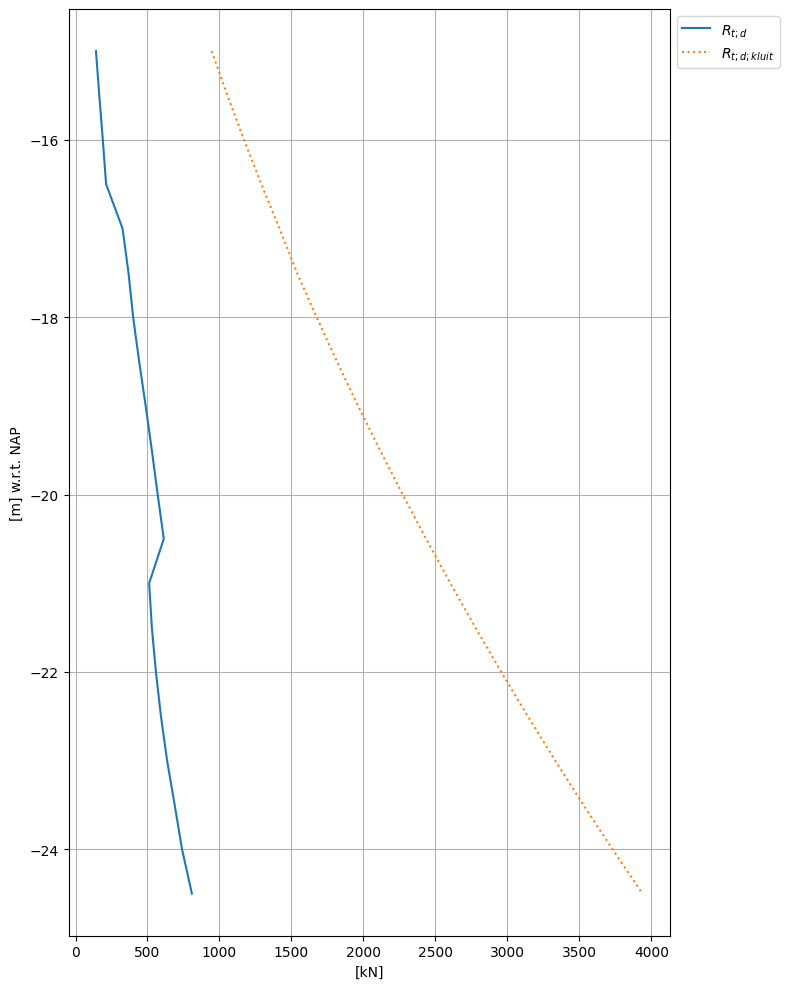

In [26]:
# plot the bearing capacities for the CPTs as a single group
multi_bearing_results.group_results_table.plot_bearing_capacities();

In [27]:
# Get the results table for the CPT group

multi_bearing_results.group_results_table.to_pandas().round(2)

,pile_tip_level_nap,s_b,s_e,k_v_b,k_v_1,var_coef,n_cpts,xi_normative,xi_value,cpt_normative,R_t_d_min,R_t_d_mean,R_t_d,R_t_d_plug,R_t_k,R_t_mob
0,-15.0,0.0,NaN,NaN,NaN,18.17,1,ξ4,1.39,CPT000000064642,194.26,213.10,142.20,945.74,190.65,NaN
1,-15.5,0.0,NaN,NaN,NaN,17.25,1,ξ4,1.39,CPT000000064642,225.59,248.31,165.23,1055.22,221.41,NaN
2,-16.0,0.0,NaN,NaN,NaN,15.68,1,ξ4,1.39,CPT000000064642,258.72,280.34,189.59,1170.21,253.94,NaN
3,-16.5,0.0,NaN,NaN,NaN,13.18,1,ξ4,1.39,CPT000000064642,289.86,308.87,212.48,1290.70,284.51,NaN
4,-17.0,0.0,1.57,NaN,88.13,11.32,8,ξ4,1.01,CPT000000064642,326.76,339.74,326.76,1416.69,435.92,349.99
5,-17.5,0.0,2.78,NaN,131.32,9.43,8,ξ3,1.27,group,368.93,368.01,368.01,1538.39,490.41,350.00
6,-18.0,0.0,2.36,NaN,152.80,8.63,8,ξ3,1.27,group,412.90,400.35,400.35,1674.34,533.39,350.00
7,-18.5,0.0,1.98,NaN,182.02,8.10,8,ξ3,1.27,group,474.36,442.06,442.06,1815.69,588.74,350.00
8,-19.0,0.0,1.54,NaN,233.86,8.29,8,ξ3,1.27,group,545.61,487.25,487.25,1962.43,648.68,350.00
9,-19.5,0.0,1.28,NaN,282.72,7.99,8,ξ3,1.27,group,604.31,530.15,530.15,2114.58,705.61,350.00


Results for individual CPTs

In [28]:
R_t_d_kluit = multi_bearing_results.cpt_results.get_results_per_cpt(
    column_name="R_t_d_plug"
).round(1)
# R_t_d_kluit.to_csv(f"{project_name} Kluidgewicht.csv")

print("Kluidgewicht")
R_t_d_kluit

Kluidgewicht


test_id,CPT000000059020,CPT000000061575,CPT000000061576,CPT000000061577,CPT000000061578,CPT000000061579,CPT000000061580,CPT000000064642
pile_tip_level_nap,,,,,,,,
-15.0,1058.6,1006.9,987.1,976.4,945.7,990.9,1002.0,988.6
-15.5,1172.9,1119.4,1098.5,1087.3,1055.2,1102.5,1114.0,1100.0
-16.0,1293.1,1237.3,1215.3,1203.7,1170.2,1219.5,1231.6,1217.0
-16.5,1418.8,1360.8,1337.7,1325.6,1290.7,1308.0,1354.7,1339.4
-17.0,1550.1,1489.8,1465.5,1453.1,1416.7,1430.0,1483.2,1467.3
-17.5,1686.8,1624.3,1598.9,1586.0,1548.2,1538.4,1617.3,1600.8
-18.0,1829.0,1764.3,1737.7,1724.4,1685.2,1674.3,1756.9,1739.7
-18.5,1976.9,1909.8,1882.1,1868.3,1827.7,1815.7,1902.0,1884.2
-19.0,2130.2,2060.9,2032.0,2017.8,1975.8,1962.4,2052.6,2034.2


In [29]:
R_t_d = multi_bearing_results.cpt_results.get_results_per_cpt(
    column_name="R_t_d"
).round(1)
# R_t_d.to_csv(f"{project_name} Schachtweerstand.csv")

print("Schachtweerstand")
R_t_d

Schachtweerstand


test_id,CPT000000059020,CPT000000061575,CPT000000061576,CPT000000061577,CPT000000061578,CPT000000061579,CPT000000061580,CPT000000064642
pile_tip_level_nap,,,,,,,,
-15.0,221.6,193.2,194.8,188.9,151.5,244.8,225.0,142.2
-15.5,248.8,223.1,227.6,222.5,185.6,287.7,259.6,165.2
-16.0,271.2,248.2,255.5,258.0,220.2,318.9,293.7,189.6
-16.5,294.3,271.6,286.3,295.0,254.6,326.0,324.3,212.5
-17.0,323.9,295.9,312.0,333.9,294.8,340.0,350.9,239.6
-17.5,355.1,320.0,333.3,374.1,336.3,348.8,360.2,270.7
-18.0,384.6,347.7,355.1,407.7,378.4,379.4,379.9,303.0
-18.5,417.8,381.1,375.3,421.0,427.0,442.3,429.1,348.4
-19.0,451.7,416.4,404.3,442.4,479.4,483.5,494.9,401.0


## Interactive Viewers

In [30]:
# Optionally define a case name for the results (to be shown in the interactive viewers)
case_name = None

In [31]:
# Parse the results into a CasesMultiCPTBearingResults
results_per_case = {
    case_name: multi_bearing_results,
}

cpt_locations = {cpt.alias: cpt.delivered_location for cpt in cptdata_objects}

cases_multi_results = CasesMultiCPTBearingResults(
    results_per_case=results_per_case, cpt_locations=cpt_locations
)

Viewer Cpt Results

In [32]:
viewer_cpt_results = ViewerCptResults(cases_multi_results=cases_multi_results)
viewer_cpt_results.display()

Viewer Cpt Results Plan View

In [33]:
viewer_cpt_results_plan_view = ViewerCptResultsPlanView(
    cases_multi_results=cases_multi_results
)
viewer_cpt_results_plan_view.display()

Viewer Cpt Group Results

In [34]:
viewer_cpt_group_results = ViewerCptGroupResults(
    cases_multi_results=cases_multi_results
)
viewer_cpt_group_results.display()

#### Single CPT inspection

It's possilbe to select one CPT from the group result. This object holds all the data releated to a singel CPT, like soil table and coneResistance.

In [35]:
# Get the available CPT names
multi_bearing_results.cpt_names

['CPT000000059020',
 'CPT000000061575',
 'CPT000000061576',
 'CPT000000061577',
 'CPT000000061578',
 'CPT000000061579',
 'CPT000000061580',
 'CPT000000064642']

In [36]:
# Select a CPT test-id to inspect
single_cpt_result = multi_bearing_results.cpt_results["CPT000000059020"]

In [37]:
# Get pandas dataframe of single-cpt results

single_cpt_result.table.to_pandas()

,pile_tip_level_nap,A,R_t_d_plug,R_t_d,R_t_k,R_t_mob_ratio,R_t_mob,k_v_b,k_v_1,q_s_max_mean,s_e,s_b
0,-15.0,24.111053,1058.623200,221.596171,295.935319,NaN,NaN,NaN,NaN,0.040184,NaN,0.0
1,-15.5,25.074151,1172.882876,248.821784,332.164472,NaN,NaN,NaN,NaN,0.041969,NaN,0.0
2,-16.0,26.036266,1293.067150,271.166933,361.931776,0.967047,350.005181,NaN,44.895322,0.043019,7.795912,0.0
3,-16.5,26.997398,1418.811605,294.298127,392.750721,0.891149,349.999319,NaN,61.824389,0.044084,5.661196,0.0
4,-17.0,27.957681,1550.051564,323.936207,432.199449,0.809805,349.997439,NaN,83.824952,0.045778,4.175368,0.0
5,-17.5,28.917702,1686.785809,355.149700,473.735917,0.738805,349.998420,NaN,121.305218,0.047555,2.885284,0.0
6,-18.0,29.877528,1829.048435,384.623150,512.973702,0.682296,349.999974,NaN,137.056822,0.049008,2.553685,0.0
7,-18.5,30.837162,1976.853472,417.758778,557.065943,0.628275,349.990487,NaN,157.044795,0.050738,2.228663,0.0
8,-19.0,31.796602,2130.198154,451.714562,602.247305,0.581135,349.987020,NaN,198.066035,0.052523,1.767087,0.0
9,-19.5,32.755848,2289.091404,483.201644,644.169696,0.543320,349.990499,NaN,222.867371,0.053895,1.570441,0.0


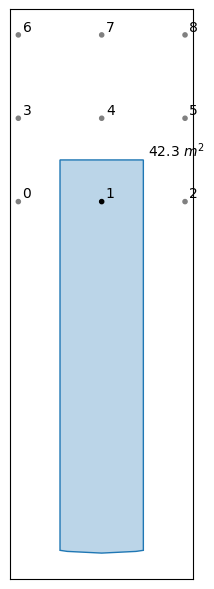

In [44]:
single_cpt_result.pile_grid_properties.plot_overview();

## Report

In [39]:
# Create report

# Close all open plots to save memory
plt.close("All")

multi_cpt_report_payload = create_multi_cpt_report_payload(
    multi_cpt_payload=multi_cpt_payload,
    project_name=project_name,
    project_id=str(project_id),
    author=author,
    date=datetime.date.today().strftime("%d-%m-%y"),
    group_results_content=group_results_content,
    individual_cpt_results_content=individual_cpt_results_content,
    result_summary_content=result_summary_content,
)

report = api.get_multi_cpt_api_report_tension(
    client=client, payload=multi_cpt_report_payload, standard=standard
)

with open(f"{project_name}_report.pdf", "wb") as f:
    f.write(report)

INFO:root:Generate report... 
Depending on the amount of pile tip levels and CPT's this can take a while.
